# CSE475 PROJECT MURA DATASET

In [50]:
import os
from PIL import Image
import matplotlib.pyplot as plt

In [51]:
DATASET_PATH = ".\\Dataset\\MURA-v1.1\\"  # Change this to your dataset path

### NO OF CLASSES

In [52]:
# Calculate and print the number of classes using the 'classes' list
train_path = os.path.join(DATASET_PATH, "train")
class_dirs = os.listdir(train_path)
num_classes = len(class_dirs)
print("There are", num_classes, "classes.")
print(class_dirs)


There are 7 classes.
['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


### Count images per class in the train directory

In [53]:
# Count images per class in the train directory
train_dir = os.path.join(DATASET_PATH, "train")
images_count = {}
for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    count_per_class = 0
    for root, dirs, files in os.walk(class_path):
        count_per_class += sum(1 for file in files if file.lower().endswith('.png'))
    images_count[class_name] = count_per_class

print("Images count per class:")
for key, value in images_count.items():
    print(f"{key}: {value}")
    

Images count per class:
XR_ELBOW: 4931
XR_FINGER: 5106
XR_FOREARM: 1825
XR_HAND: 5543
XR_HUMERUS: 1272
XR_SHOULDER: 8379
XR_WRIST: 9756


### SAMPLE IMG

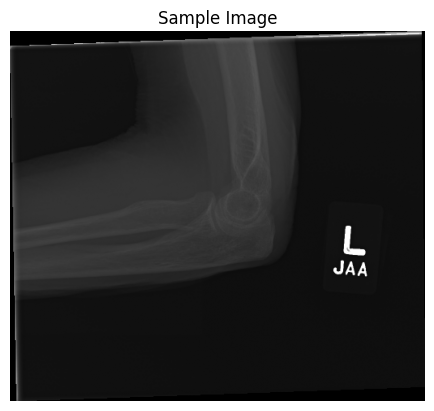

In [54]:
sample_img_path = 'Dataset\\MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png'
sample_img = Image.open(sample_img_path)
plt.imshow(sample_img, cmap='gray')
plt.axis('off')
plt.title('Sample Image')
plt.show()

### PLOT DISTRIBUTION

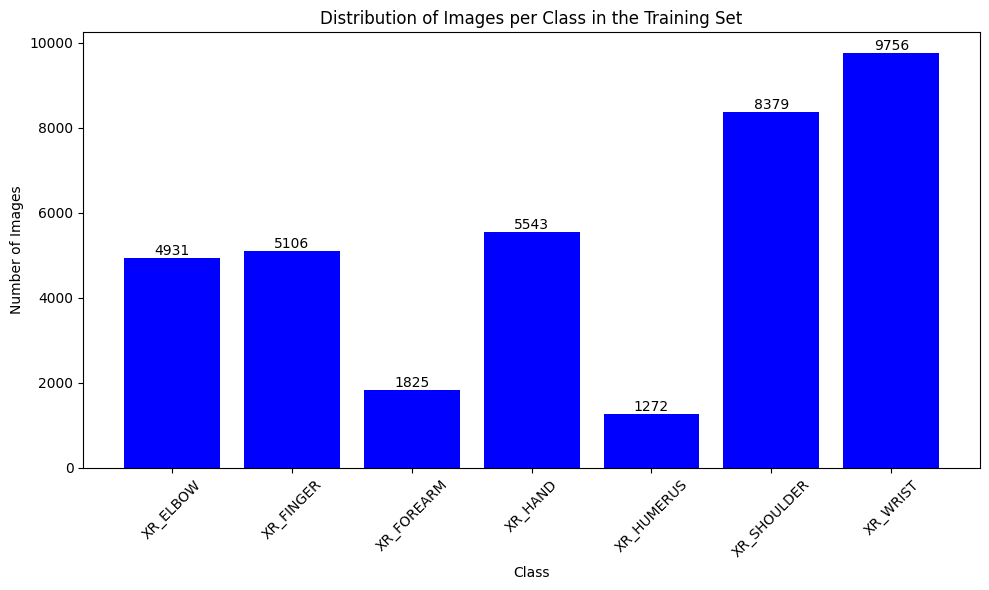

In [55]:
classes_list = list(images_count.keys())
counts_list = list(images_count.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(classes_list, counts_list, color='blue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in the Training Set')
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels at the top of each bar
for bar, count in zip(bars, counts_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()